# Movie Feature Selection 

This notebook works through some of yellowbrick's functions to select the most important features in our movies dataset.  We will use Rank2D, parallel coordinates, radviz, and FeatureSelection.  Lastly, we will run some preliminary models to run some validation curves to get some knowledge of the hyperparameters in the RandomForestClassifier.  The related GitHub for this project is here: https://github.com/georgetown-analytics/Box-Office.  

The raw data sources were cleaned, wrangled, and pre-processed in separate python codes stored here: https://github.com/georgetown-analytics/Box-Office/tree/master/codes.  These notebooks are for the feature selection stage of the project.

In [4]:
import pandas as pd
import numpy as np
import pandas.io.sql as pd_sql
import sqlite3 as sql
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

from yellowbrick.features import Rank2D, ParallelCoordinates, RadViz, FeatureImportances
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.classifier import ROCAUC, ClassificationReport, ConfusionMatrix

from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split as tts

from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (BaggingClassifier, ExtraTreesClassifier, 
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier

%matplotlib notebook

In [5]:
con = sql.connect(r'c:\users\rebecca\projs\Box-Office\database\movies.db') 

movies = pd_sql.read_sql('select * from finalMovies_20180814', con, index_col='index')


### Limit dataset to movies that will be used in modeling.

We will create the new feature "Profit_Bucket_Binary", convert any "nan" in the historical cast/crew revenue columns to 0. 

In [6]:
#Limit dataset to those with filled in Revenue, Budget, and Length columns.  Based on what I've seen, this helps to
#get rid of remaining duplicates in dataset.  Also helps to narrow down dataset to test profitability, where we
#need both revenue and budget filled in.  We could experiment with movies with revenue greater than $100,000, if 
#we choose to.
test = movies[(movies['Revenue_Real']>0)&(movies['Budget_Real']>0)&(movies['Length']>0)]

#Make binary variable for if movie made at least 2x budget
test['Profit_Bucket_Binary']=np.where(test['Profit_Bucket']=='<1x', 0, np.where(test['Profit_Bucket']=='[1-2x)', 
                        0, np.where(test['Profit_Bucket']=='[2-3x)', 1, np.where(test['Profit_Bucket']=='[3-4x)', 
                        1, np.where(test['Profit_Bucket']=='[4-5x)', 1, np.where(test['Profit_Bucket']=='>=5x', 1, ''))))))

#Put zero where null
test['Revenue_Actor_Real']=movies['Revenue_Actor_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test['Revenue_Director_Real']=movies['Revenue_Director_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test['Revenue_Writer_Real']=movies['Revenue_Writer_Real'].apply(lambda x: 0 if pd.isnull(x) else x)


C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

# Use Rank2D function to see correlations among features

We will look at the main ~40 features in our dataset to see the correlations. 

<IPython.core.display.Javascript object>


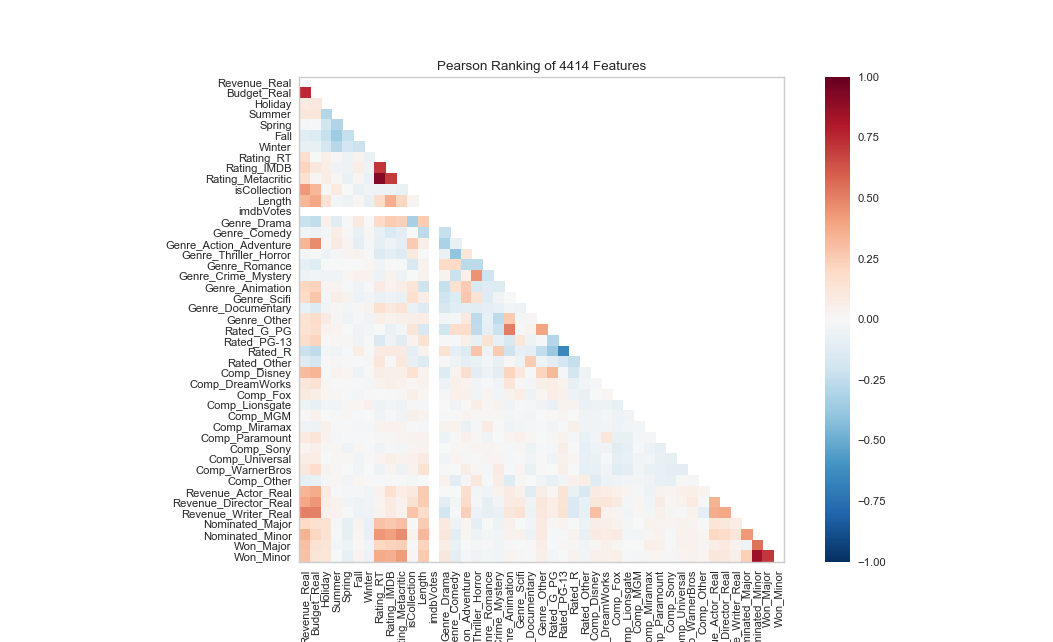

In [57]:
%matplotlib notebook

#Include Revenue variable to see what it correlates with.
features = test[["Revenue_Real","Budget_Real", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length', 'imdbVotes',
'Genre_Drama','Genre_Comedy','Genre_Action_Adventure','Genre_Thriller_Horror','Genre_Romance',
 'Genre_Crime_Mystery','Genre_Animation','Genre_Scifi','Genre_Documentary','Genre_Other',      
'Rated_G_PG','Rated_PG-13','Rated_R','Rated_Other','Comp_Disney','Comp_DreamWorks','Comp_Fox',
'Comp_Lionsgate','Comp_MGM','Comp_Miramax','Comp_Paramount','Comp_Sony','Comp_Universal',
'Comp_WarnerBros','Comp_Other', 'Revenue_Actor_Real','Revenue_Director_Real', 'Revenue_Writer_Real',
'Nominated_Major', 'Nominated_Minor', 'Won_Major', 'Won_Minor']]
labels = test["Profit_Bucket_Binary"]
oz = Rank2D(features=features)
oz.fit_transform(features, labels)
oz.poof()

# Use Parallel Coordinates/Radviz functions 

Look at what features influence profit buckets 

In [58]:
label_encoder = LabelEncoder()
yc = label_encoder.fit_transform(labels)

<IPython.core.display.Javascript object>


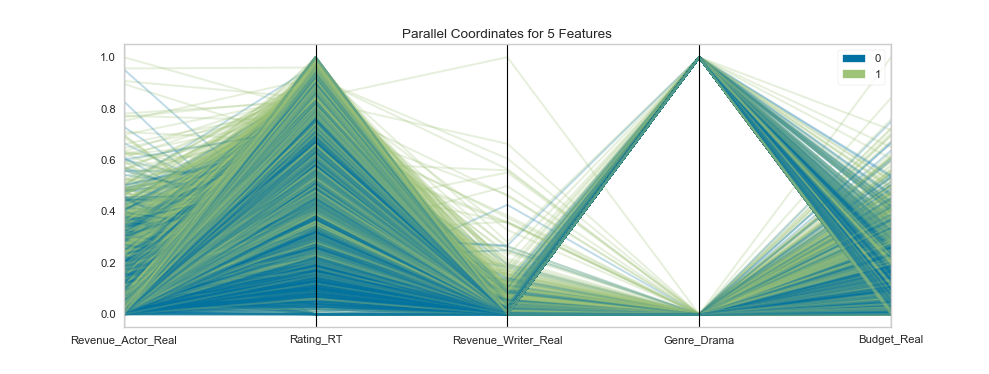

In [59]:
oz = ParallelCoordinates(normalize='minmax') #minmax, standard
oz.fit_transform(test[['Revenue_Actor_Real', 'Rating_RT', 
                        'Revenue_Writer_Real', 'Genre_Drama', 'Budget_Real']], test['Profit_Bucket_Binary']) 
oz.poof()

<IPython.core.display.Javascript object>


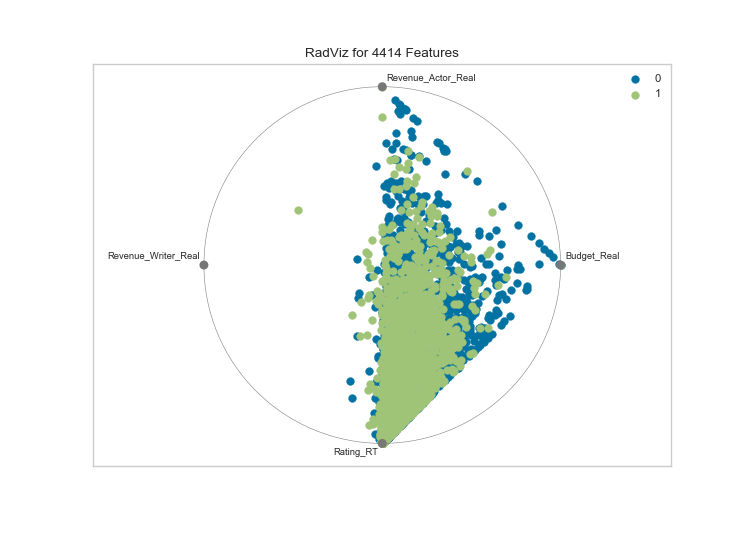

In [60]:
yc = label_encoder.fit_transform(test['Profit_Bucket_Binary'])
features = test[[('Budget_Real'), 'Revenue_Actor_Real', 'Revenue_Writer_Real', 'Rating_RT']]
oz = RadViz(classes=label_encoder.classes_, features=features)
oz.fit(features, yc)
oz.poof()

# Use FeatureImportances with some preliminary models

Look at what features influence profit buckets 

In [8]:
features = test[["Budget_Real", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic',           
'isCollection','Length',  
'Genre_Drama','Genre_Comedy','Genre_Action_Adventure','Genre_Thriller_Horror','Genre_Romance',
 'Genre_Crime_Mystery','Genre_Animation','Genre_Scifi','Genre_Documentary','Genre_Other',      
'Rated_G_PG','Rated_PG-13','Rated_R','Rated_Other',         
'Comp_Disney','Comp_DreamWorks','Comp_Fox','Comp_Lionsgate','Comp_MGM',
 'Comp_Miramax','Comp_Paramount','Comp_Sony','Comp_Universal','Comp_WarnerBros','Comp_Other',           
'Revenue_Actor_Real','Revenue_Director_Real', 'Revenue_Writer_Real',
'Nominated_Major', 'Nominated_Minor', 'Won_Major', 'Won_Minor'
]]
labels = test["Profit_Bucket_Binary"]

<IPython.core.display.Javascript object>


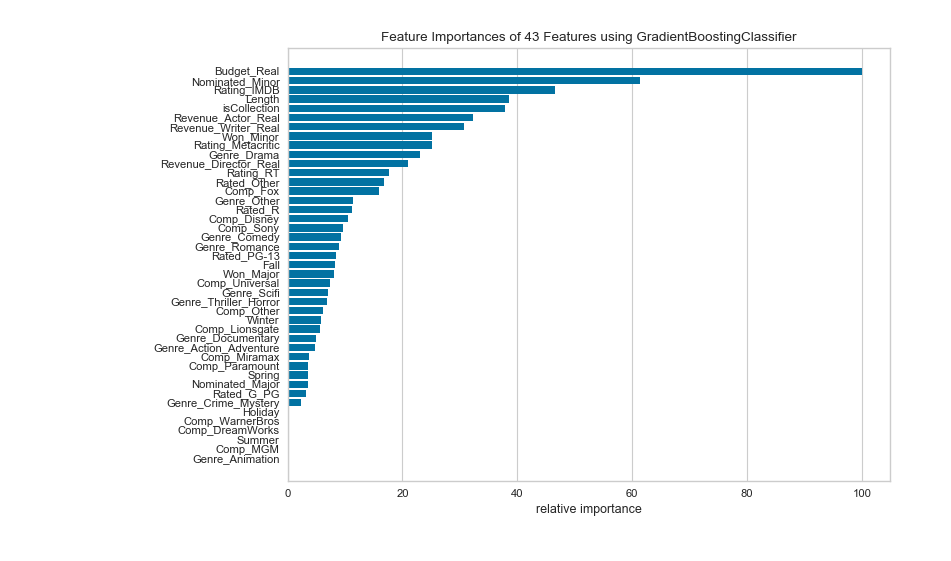

In [62]:
%matplotlib notebook
model = GradientBoostingClassifier()
oz=FeatureImportances(GradientBoostingClassifier())
oz.fit(features, labels)
oz.poof()

<IPython.core.display.Javascript object>


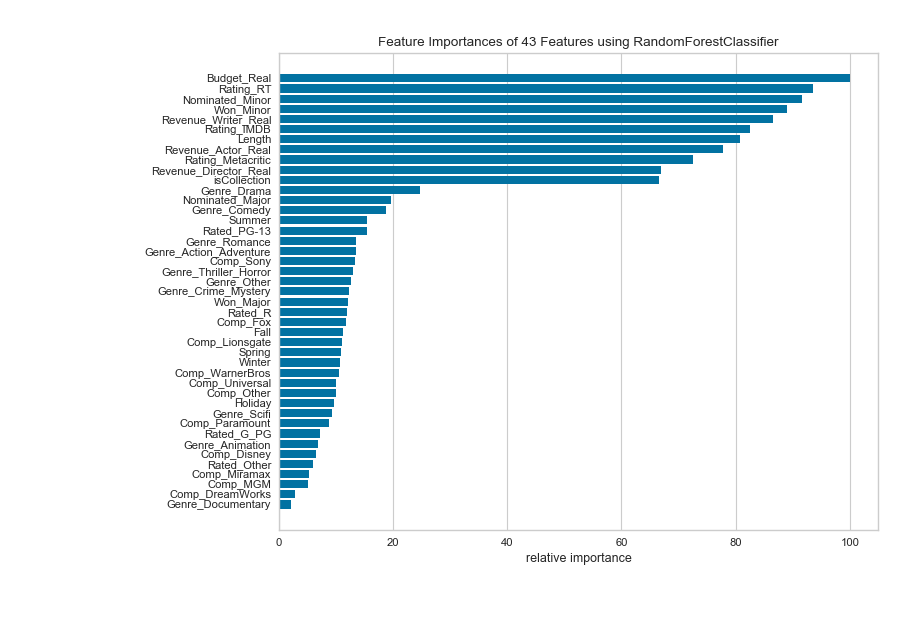

In [63]:
%matplotlib notebook
oz=FeatureImportances(RandomForestClassifier())
oz.fit(features, labels)
oz.poof()

<IPython.core.display.Javascript object>


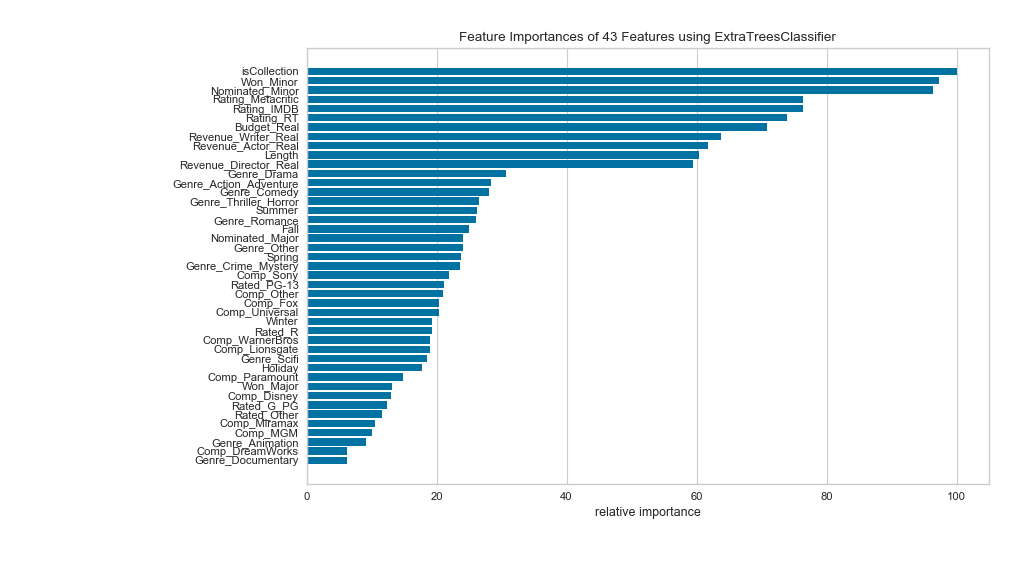

In [64]:
%matplotlib notebook
oz=FeatureImportances(ExtraTreesClassifier())
oz.fit(features, labels)
oz.poof()

<IPython.core.display.Javascript object>


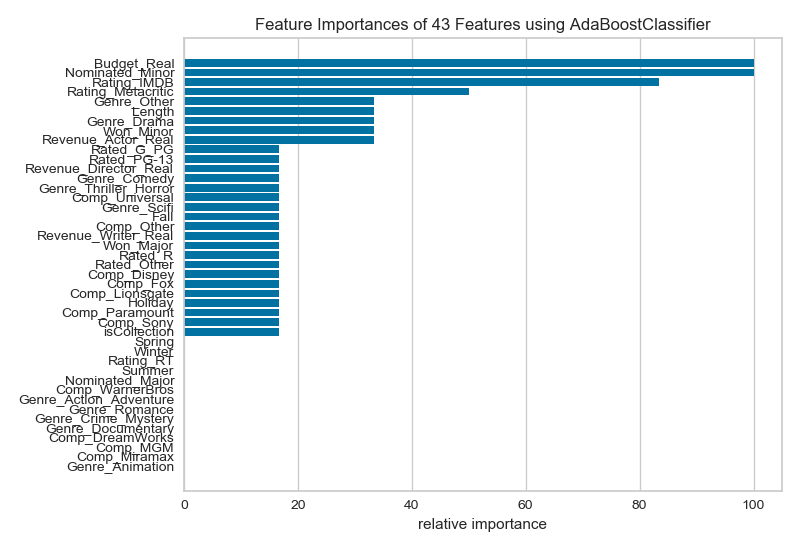

In [10]:
%matplotlib notebook
oz=FeatureImportances(AdaBoostClassifier())
oz.fit(features, labels)
oz.poof()

<IPython.core.display.Javascript object>


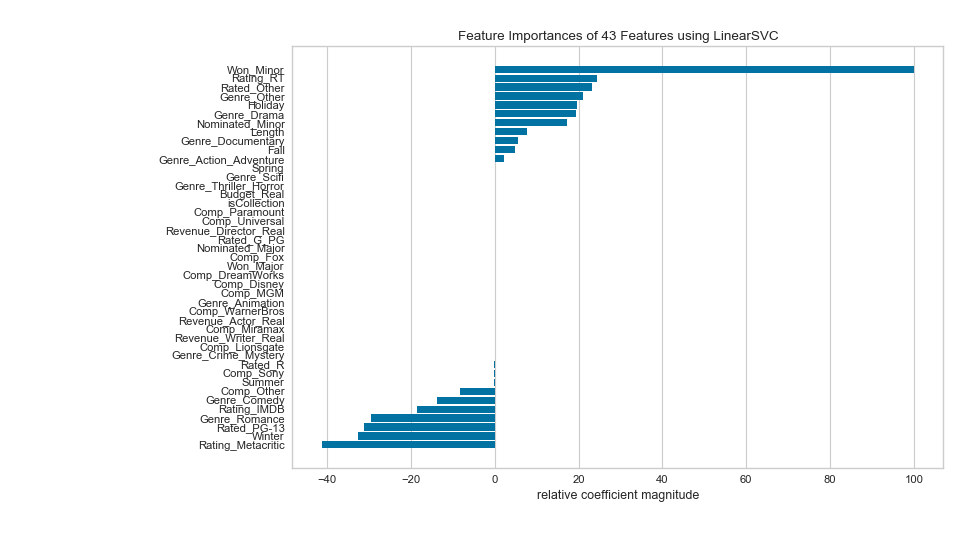

In [65]:
%matplotlib notebook
oz=FeatureImportances(LinearSVC())
oz.fit(features, labels)
oz.poof()

# Use ValidationCurve with some preliminary models

Look at what hyperparameters can be tuned in RandomForestClassifier

<IPython.core.display.Javascript object>


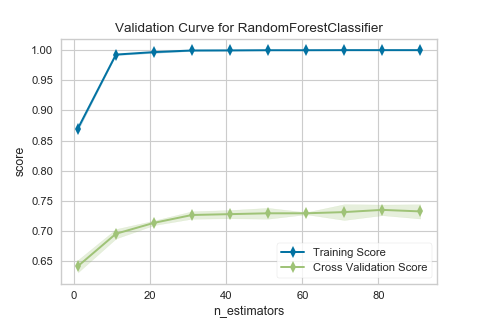

In [66]:
X_train, X_test, y_train, y_test = tts(features, labels, test_size=0.2)
oz = ValidationCurve(RandomForestClassifier(), param_name='n_estimators', param_range=np.arange(1, 100, 10))
oz.fit(X_train, y_train)
oz.poof()

<IPython.core.display.Javascript object>


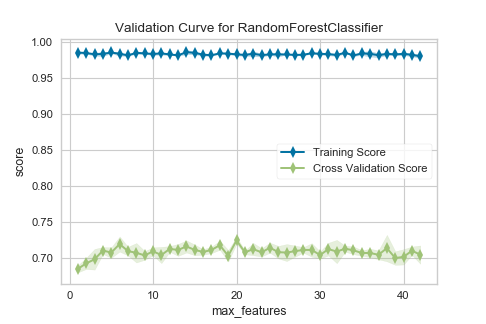

In [67]:
oz = ValidationCurve(RandomForestClassifier(), param_name='max_features', param_range=np.arange(1, 43, 1))
oz.fit(X_train, y_train)
oz.poof()

<IPython.core.display.Javascript object>


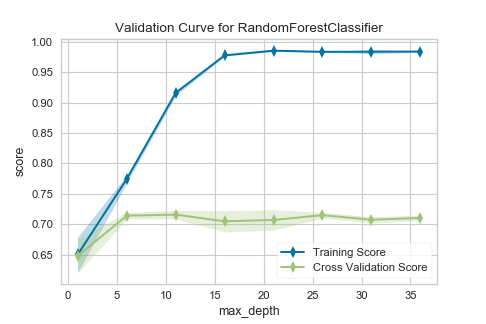

In [68]:
oz = ValidationCurve(RandomForestClassifier(), param_name='max_depth', param_range=np.arange(1, 40, 5))
oz.fit(X_train, y_train)
oz.poof()

<IPython.core.display.Javascript object>


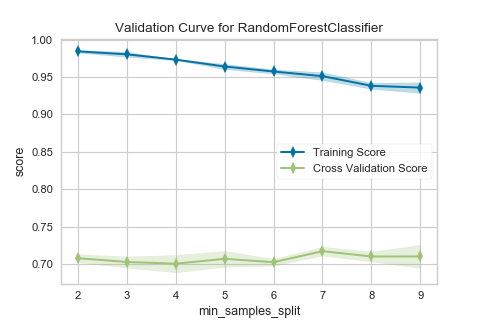

In [69]:
oz = ValidationCurve(RandomForestClassifier(), param_name='min_samples_split', param_range=np.arange(2, 10, 1))
oz.fit(X_train, y_train)
oz.poof()

<IPython.core.display.Javascript object>


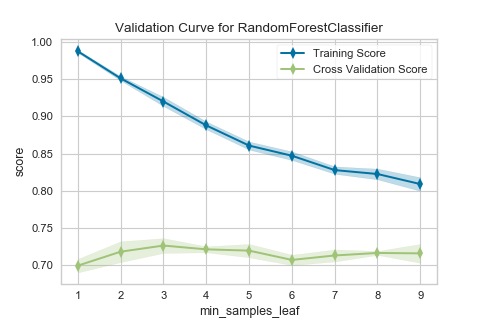

In [70]:
oz = ValidationCurve(RandomForestClassifier(), param_name='min_samples_leaf', param_range=np.arange(1, 10, 1))
oz.fit(X_train, y_train)
oz.poof()

## ----------------------------------------
## Look at some models

Initial experiments with classification models 
## ----------------------------------------

In [28]:
features = test[["Budget_Real", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic',           
'isCollection','Length',    
'Genre_Drama','Genre_Comedy','Genre_Action_Adventure','Genre_Thriller_Horror','Genre_Romance',
 'Genre_Crime_Mystery','Genre_Animation','Genre_Scifi','Genre_Documentary','Genre_Other',     
'Rated_G_PG','Rated_PG-13','Rated_R','Rated_Other',       
'Comp_Disney','Comp_DreamWorks','Comp_Fox','Comp_Lionsgate','Comp_MGM',
 'Comp_Miramax','Comp_Paramount','Comp_Sony','Comp_Universal','Comp_WarnerBros','Comp_Other',          
'Revenue_Actor_Real','Revenue_Director_Real', 'Revenue_Writer_Real',
'Nominated_Major', 'Nominated_Minor', 'Won_Major', 'Won_Minor'
]]
labels = test["Profit_Bucket_Binary"]

X_train, X_test, y_train, y_test = tts(features, labels, test_size=0.2)

<IPython.core.display.Javascript object>


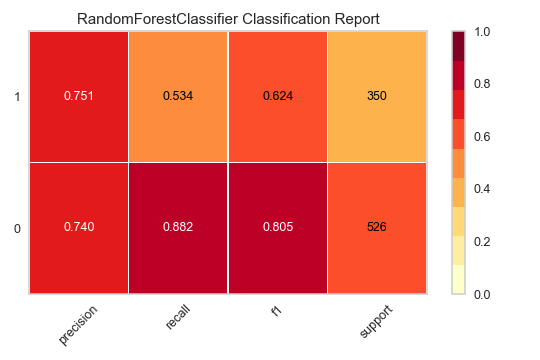

In [29]:
model = RandomForestClassifier()

oz = ClassificationReport(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

<IPython.core.display.Javascript object>


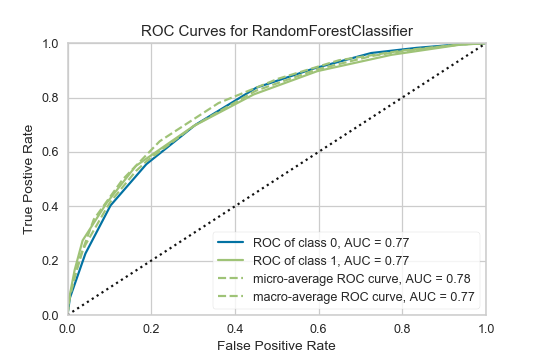

In [30]:
label_encoder = LabelEncoder()
yc = label_encoder.fit_transform(labels)

oz = ROCAUC(model, support=True, classes=label_encoder.classes_)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

<IPython.core.display.Javascript object>


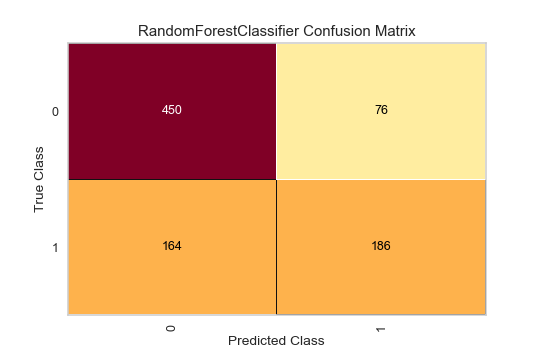

In [31]:
oz = ConfusionMatrix(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

In [32]:
feature_importances = pd.DataFrame(model.feature_importances_,
   index = X_train.columns,columns=['importance']).sort_values('importance',
    ascending=False)
(feature_importances.head(10))

,importance
Nominated_Minor,0.081916
Budget_Real,0.078689
Revenue_Writer_Real,0.069771
Rating_RT,0.067764
Rating_IMDB,0.066377
Revenue_Actor_Real,0.063798
Length,0.061272
Won_Minor,0.060698
Rating_Metacritic,0.059229
isCollection,0.048366


---------------
Test boostrap = False
----------------

<IPython.core.display.Javascript object>


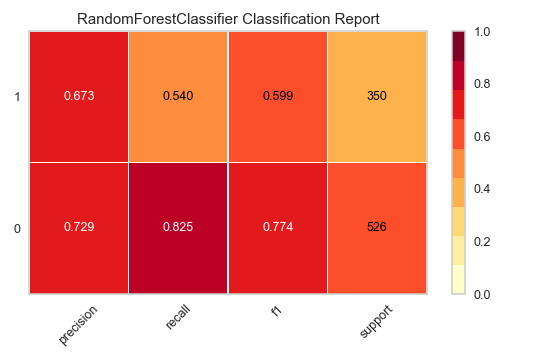

In [33]:
model = RandomForestClassifier(bootstrap=False)
oz = ClassificationReport(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

<IPython.core.display.Javascript object>


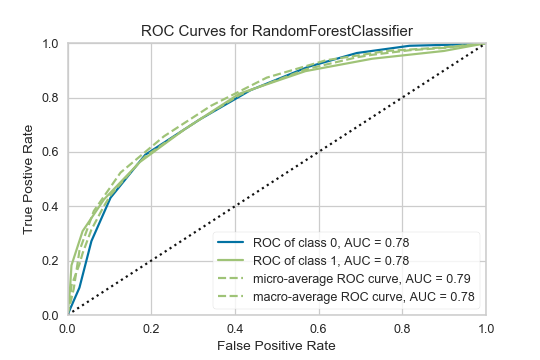

In [34]:
label_encoder = LabelEncoder()
yc = label_encoder.fit_transform(labels)

oz = ROCAUC(model, support=True, classes=label_encoder.classes_)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

In [35]:
feature_importances = pd.DataFrame(model.feature_importances_,
   index = X_train.columns,columns=['importance']).sort_values('importance',
    ascending=False)
(feature_importances.head(10))

,importance
Nominated_Minor,0.081722
Budget_Real,0.081687
Rating_RT,0.068909
Rating_IMDB,0.067833
Revenue_Actor_Real,0.067111
Rating_Metacritic,0.063565
Revenue_Writer_Real,0.061290
Length,0.061274
Won_Minor,0.060063
Revenue_Director_Real,0.052858
